In [788]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, EfficientFrontier, objective_functions
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso 
from sklearn.metrics import r2_score

from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='', output_format='pandas')

In [560]:
data, meta_data = ts.get_daily_adjusted(symbol='LREN3.SA', outputsize='full')

In [460]:
# Setting up pipeline
# factor_dict = {}
# Factor exposures:
_etfs = ['IYC']

for ticker in _etfs:
    temp_data, temp_meta_data = ts.get_daily_adjusted(symbol=ticker, outputsize='full')
    factor_dict[ticker] = temp_data

IYC


In [566]:
factor_etfs = ['JO','SOYB','WEAT','CORN', 'XLI', 'IYC']

In [567]:
processed_factor_dict = {}

for ticker in factor_etfs:
    temp_df = factor_dict[ticker]
    temp_df['daily return'] = temp_df.loc[:,'5. adjusted close'].pct_change()
    processed_factor_dict[ticker] = temp_df

In [789]:
# Building X dataframe for linear regression:
X = pd.DataFrame(index=data.index)
X = X.sort_index()
for ticker in factor_etfs:
    X[f'{ticker} Daily Returns'] = processed_factor_dict[ticker]['daily return'].sort_index()

X = X.dropna()
# X.sort_index(inplace=True)

In [790]:
X

,JO Daily Returns,SOYB Daily Returns,WEAT Daily Returns,CORN Daily Returns,XLI Daily Returns,IYC Daily Returns
date,,,,,,
2018-02-01,0.009204,0.008291,0.009600,0.001753,0.020516,0.011719
2018-02-02,0.004727,0.008954,0.009693,0.007656,0.047548,0.036270
2018-02-05,-0.024369,-0.018559,-0.012759,-0.012216,-0.017939,-0.020862
2018-02-06,0.000008,0.003891,-0.026398,-0.003478,-0.001843,0.000584
2018-02-07,-0.000008,-0.001149,0.010989,0.001161,0.040126,0.042065
...,...,...,...,...,...,...
2020-07-27,0.013662,0.011794,0.005639,0.012753,0.006979,0.007553
2020-07-28,-0.026879,0.000000,-0.012987,0.005983,-0.014987,-0.009321
2020-07-29,-0.026175,-0.002114,0.006536,-0.002558,0.010139,0.001113


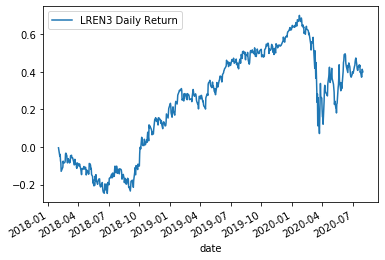

In [791]:
y = pd.DataFrame(index = data.index)
y = y.sort_index()
y['LREN3 Daily Return'] = data.loc[:,'5. adjusted close'].sort_index().pct_change()
etf_df = y.merge(right=X, how='inner', left_index=True, right_index=True)
y = y.loc[etf_df.index]
y.dropna(inplace=True)
X = X.loc[y.index]
X.dropna(inplace=True)
y.cumsum().plot()

In [792]:
reg = LinearRegression().fit(X,y)
print(reg.coef_)
print(reg.intercept_)

[[ 0.04517775 -0.09289595  0.00874534 -0.13701358 -0.19779874  0.54755811]]
[0.00087449]


In [793]:
r2_score(y, reg.predict(X))

0.03848335788213142

In [795]:
etf_df

,LREN3 Daily Return,JO Daily Returns,SOYB Daily Returns,WEAT Daily Returns,CORN Daily Returns,XLI Daily Returns,IYC Daily Returns
date,,,,,,,
2018-02-01,-0.004493,0.009204,0.008291,0.009600,0.001753,0.020516,0.011719
2018-02-02,-0.011408,0.004727,0.008954,0.009693,0.007656,0.047548,0.036270
2018-02-05,-0.034624,-0.024369,-0.018559,-0.012759,-0.012216,-0.017939,-0.020862
2018-02-06,0.010843,0.000008,0.003891,-0.026398,-0.003478,-0.001843,0.000584
2018-02-07,-0.033278,-0.000008,-0.001149,0.010989,0.001161,0.040126,0.042065
...,...,...,...,...,...,...,...
2020-07-27,-0.029126,0.013662,0.011794,0.005639,0.012753,0.006979,0.007553
2020-07-28,0.003750,-0.026879,0.000000,-0.012987,0.005983,-0.014987,-0.009321
2020-07-29,0.038605,-0.026175,-0.002114,0.006536,-0.002558,0.010139,0.001113


In [796]:
mu = expected_returns.mean_historical_return(etf_df, returns_data=True)
S = risk_models.sample_cov(etf_df, returns_data=True)

In [797]:
ef_2 = EfficientFrontier(mu, S)
ef_2.add_objective(objective_functions.L2_reg, gamma=5)

In [798]:
raw_weights = ef_2.max_sharpe()
cleaned_weights = ef_2.clean_weights()
ef_2.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef_2.portfolio_performance(verbose=True)

OrderedDict([('LREN3 Daily Return', 0.21469), ('JO Daily Returns', 0.22709), ('SOYB Daily Returns', 0.14222), ('WEAT Daily Returns', 0.11246), ('CORN Daily Returns', 0.21873), ('XLI Daily Returns', 0.0848), ('IYC Daily Returns', 0.0)])
Expected annual return: 14.5%
Annual volatility: 15.6%
Sharpe Ratio: 0.80


C:\Users\raahimsal\Anaconda3\lib\site-packages\pypfopt\efficient_frontier.py:182: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


(0.14528221438042843, 0.1560175568979435, 0.8030007447327219)

In [773]:
weights

,LREN3 Daily Return,0.21469
0,JO Daily Returns,0.22709
1,SOYB Daily Returns,0.14222
2,WEAT Daily Returns,0.11246
3,CORN Daily Returns,0.21873
4,XLI Daily Returns,0.08480
5,IYC Daily Returns,0.00000


In [776]:
# etf_df.to_csv('etf_df.csv')

In [801]:
weights = [0.21469,0.22709,0.14222,0.11246, 0.21873, 0.08480, 0.0] 

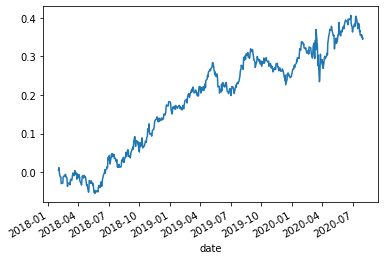

In [802]:
test = etf_df * weights

testt = test.sum(axis=1)
testt.cumsum().plot()

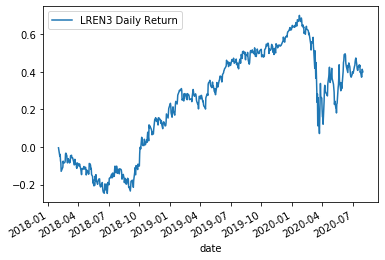

In [804]:
y.cumsum().plot()